## Blocket car data

### Jonas Lundgren  
### Last Updated: Jan 26, 2019

---  

### Sources 

https://www.youtube.com/watch?v=XQgXKtPSzUI&t=0s&index=2&list=LLgrRgAlce_d0J02aHPrp4nA

University of California, Santa Barbara: PSTAT 135/235, winter quarter 2019

### Explanation
- Part 1: Webscraping of cars for sale in Skåne, Sweden from private sellers. Scraping is done from Swedish buy and sell site https://www.blocket.se/ using BeautifulSoup.
- Part 2: Data preprocessing done using pySpark since I wanted to practice and was not necessary for a data set containing about 2500 rows (scraping done on Jan 26 2019). Visualizations are done using pandas and matplotlib.

#### Note: 
Formating of the webpage where the scraping was done could change if this is read at a later time.

---  

### Part 1
Loading packages used for webscraping.

In [1]:
import requests
from bs4 import BeautifulSoup

Url to the site where scraping will be done.

In [2]:
my_url = 'https://www.blocket.se/malmo/bilar?ca=23_11&cg=1020&st=s&l=0&f=p&w=1'
client = requests.get(my_url).text

In [3]:
soup = BeautifulSoup(client, "html.parser")

The path in the html file we are interested in.

In [4]:
cars = soup.find_all('div', {'id': 'item_list'})[0].find_all('article')

Testing to scrape data from the second car on blocket to see if everything is ok

In [5]:
info = cars[1]
location = info.div.div.text
date = info.div.time.get('datetime')
title = info.div.find('a', {'class': 'item_link'}).text.replace(',', '|')

splited_info = info.div.p.text.split(' | ')

fuel = splited_info[0]
gear = splited_info[1]
dist = splited_info[2]
price = info.div.find('p', {'class' : 'list_price font-large'}).text



Testing to loop over all cars on the first page of cars in the wanted region. If the # signs are removed a file called "blocket_cars.csv" is stored containing the cars at the first page.

In [6]:
filename = "blocket_cars.csv"
#f = open(filename, "w")
headers = "date, title, dist, price, fuel, gear, location\n"
#f.write(headers)

for car in cars:
    info = car
   
    date = info.div.time.get('datetime')
    title = info.div.find('a', {'class': 'item_link'}).text.replace(',', '|')

    splited_info = info.div.p.text.split(' | ')

    fuel = splited_info[0]
    gear = splited_info[1]
    dist = splited_info[2]
    price = info.div.find('p', {'class' : 'list_price font-large'}).text
    location = info.div.div.text

    #f.write(date + "," + title + "," + dist + "," + price + "," + fuel + "," + gear + "," + location + "\n")
    
#f.close()

Here a file called "blocket_cars.csv" is created containing all cars in Skåne not from resellers is stored. The while loop loops over all pages on blocket with the search results we are interested in. At current time it was 52 pages. For every page we loop over the number of cars and store the data we are interseted in: date, title, dist, price, fuel, gear, location. The page number is printed to see how far the scraping process has passed. 

In [7]:
filename = "blocket_cars.csv"
f = open(filename, "w")
headers = "date, title, dist, price, fuel, gear, location\n"
f.write(headers)
stop = 'NA'
i = 1

while(stop != 'Inga träffar i Bilar'):
    
    my_url = 'https://www.blocket.se/malmo/bilar?ca=23_11&cg=1020&st=s&l=0&f=p&w=1&o=' + str(i)

    client = requests.get(my_url).text

    soup = BeautifulSoup(client, "html.parser")
    
    try:
        stop = soup.find_all('div', {'class': 'ads_not_found col-xs-12'})[0].h3.text
    except:
        print('Page number: ' + str(i))
    
    cars = soup.find_all('div', {'id': 'item_list'})[0].find_all('article')
    
    for car in cars:
        info = car
        
        if(info.div.p.text == ''):
            break
        
        date = info.div.time.get('datetime')
        title = info.div.find('a', {'class': 'item_link'}).text.replace(',', '|')

        splited_info = info.div.p.text.split(' | ')
        
        fuel = splited_info[0]
        gear = splited_info[1]
        dist = splited_info[2]
        price = info.div.find('p', {'class' : 'list_price font-large'}).text
        location = info.div.div.text

        f.write(date + "," + title + "," + dist + "," + price + "," + fuel + "," + gear + "," + location + "\n")
    
    i = i+1
    
f.close()

Page number: 1
Page number: 2
Page number: 3
Page number: 4
Page number: 5
Page number: 6
Page number: 7
Page number: 8
Page number: 9
Page number: 10
Page number: 11
Page number: 12
Page number: 13
Page number: 14
Page number: 15
Page number: 16
Page number: 17
Page number: 18
Page number: 19
Page number: 20
Page number: 21
Page number: 22
Page number: 23
Page number: 24
Page number: 25
Page number: 26
Page number: 27
Page number: 28
Page number: 29
Page number: 30
Page number: 31
Page number: 32
Page number: 33
Page number: 34
Page number: 35
Page number: 36
Page number: 37
Page number: 38
Page number: 39
Page number: 40
Page number: 41
Page number: 42
Page number: 43
Page number: 44
Page number: 45
Page number: 46
Page number: 47
Page number: 48
Page number: 49
Page number: 50
Page number: 51


### Part 2

SparkSession is imported aswell as other spark packages

In [8]:
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
from pyspark.sql.functions import *
import pandas

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("review_and_category_analytics") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

The data is read into a data frame called df.

In [9]:
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("ignoreLeadingWhiteSpace",'true')\
    .load("blocket_cars.csv")

The data frame df is saved.

In [10]:
df.cache()

DataFrame[date: string, title: string, dist: string, price: string, fuel: string, gear: string, location: string]

First 5 rows are displayed

In [11]:
df.show(5)

+-------------------+--------------------+-------------------+----------+-------------------+-------+--------------+
|               date|               title|               dist|     price|               fuel|   gear|      location|
+-------------------+--------------------+-------------------+----------+-------------------+-------+--------------+
|2019-01-26 23:16:46|VW Jetta 1|6 mult...|  3 500 - 3 999 mil| 88 000 kr|Miljöbränsle/Hybrid|Manuell|Centralt Söder|
|2019-01-26 23:11:44|  Opel Astra 2.0 -11|17 500 - 17 999 mil| 47 000 kr|             Diesel|Automat|Centralt Söder|
|2019-01-26 23:11:19|Toyota Auris Hybr...|  7 500 - 7 999 mil|149 900 kr|Miljöbränsle/Hybrid|Automat|   Helsingborg|
|2019-01-26 23:09:21|Kia Sportage 1.7 ...|15 000 - 15 499 mil| 82 900 kr|             Diesel|Manuell|    Landskrona|
|2019-01-26 23:09:14|Toyota Avensis Ve...|19 500 - 19 999 mil| 34 900 kr|             Bensin|Manuell| Centralt Norr|
+-------------------+--------------------+-------------------+--

In [12]:
df.columns

['date', 'title', 'dist', 'price', 'fuel', 'gear', 'location']

In [13]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- dist: string (nullable = true)
 |-- price: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- gear: string (nullable = true)
 |-- location: string (nullable = true)



Lower casing all caps in the the title.

In [14]:
df = df.withColumn('title', lower(df.title))

Removing the currency sign kr and the space in the price.

In [15]:
df = df\
        .withColumn('price', regexp_replace('price', ' kr', ''))\
        .withColumn('price', regexp_replace('price', ' ', ''))

Convering the price to int.

In [16]:
df = df.withColumn('price', df['price'].cast("int"))

Checking the results

In [17]:
df.show(5)

+-------------------+--------------------+-------------------+------+-------------------+-------+--------------+
|               date|               title|               dist| price|               fuel|   gear|      location|
+-------------------+--------------------+-------------------+------+-------------------+-------+--------------+
|2019-01-26 23:16:46|vw jetta 1|6 mult...|  3 500 - 3 999 mil| 88000|Miljöbränsle/Hybrid|Manuell|Centralt Söder|
|2019-01-26 23:11:44|  opel astra 2.0 -11|17 500 - 17 999 mil| 47000|             Diesel|Automat|Centralt Söder|
|2019-01-26 23:11:19|toyota auris hybr...|  7 500 - 7 999 mil|149900|Miljöbränsle/Hybrid|Automat|   Helsingborg|
|2019-01-26 23:09:21|kia sportage 1.7 ...|15 000 - 15 499 mil| 82900|             Diesel|Manuell|    Landskrona|
|2019-01-26 23:09:14|toyota avensis ve...|19 500 - 19 999 mil| 34900|             Bensin|Manuell| Centralt Norr|
+-------------------+--------------------+-------------------+------+-------------------+-------

Removing mil from the distance the car has traveled.

In [18]:
df = df.withColumn('dist', regexp_replace('dist', ' mil', ''))

Creating a split in the distance the car has traveled.

In [19]:
split_col = split(df['dist'], ' - ')

Creating 2 columns with distance range.

In [20]:
df = df.withColumn('from', split_col.getItem(0))
df = df.withColumn('to', split_col.getItem(1))

Converingt the distance to ints.

In [21]:
df = df.withColumn('from', regexp_replace('from', ' ', ''))
df = df.withColumn('from', df['from'].cast("int"))

df = df.withColumn('to', regexp_replace('to', ' ', ''))
df = df.withColumn('to', df['to'].cast("int"))

In [22]:
df.show(5)

+-------------------+--------------------+---------------+------+-------------------+-------+--------------+-----+-----+
|               date|               title|           dist| price|               fuel|   gear|      location| from|   to|
+-------------------+--------------------+---------------+------+-------------------+-------+--------------+-----+-----+
|2019-01-26 23:16:46|vw jetta 1|6 mult...|  3 500 - 3 999| 88000|Miljöbränsle/Hybrid|Manuell|Centralt Söder| 3500| 3999|
|2019-01-26 23:11:44|  opel astra 2.0 -11|17 500 - 17 999| 47000|             Diesel|Automat|Centralt Söder|17500|17999|
|2019-01-26 23:11:19|toyota auris hybr...|  7 500 - 7 999|149900|Miljöbränsle/Hybrid|Automat|   Helsingborg| 7500| 7999|
|2019-01-26 23:09:21|kia sportage 1.7 ...|15 000 - 15 499| 82900|             Diesel|Manuell|    Landskrona|15000|15499|
|2019-01-26 23:09:14|toyota avensis ve...|19 500 - 19 999| 34900|             Bensin|Manuell| Centralt Norr|19500|19999|
+-------------------+-----------

Splitting the title to get the brand and model of car. The split is done in a sloppy way and there are several cars where the title was not on form: brand model ... This problem is ignored for now.

In [23]:
split_col = split(df['title'], ' ')

In [24]:
df = df.withColumn('brand', split_col.getItem(0))
df = df.withColumn('model', split_col.getItem(1))

In [25]:
df.show(5)

+-------------------+--------------------+---------------+------+-------------------+-------+--------------+-----+-----+------+--------+
|               date|               title|           dist| price|               fuel|   gear|      location| from|   to| brand|   model|
+-------------------+--------------------+---------------+------+-------------------+-------+--------------+-----+-----+------+--------+
|2019-01-26 23:16:46|vw jetta 1|6 mult...|  3 500 - 3 999| 88000|Miljöbränsle/Hybrid|Manuell|Centralt Söder| 3500| 3999|    vw|   jetta|
|2019-01-26 23:11:44|  opel astra 2.0 -11|17 500 - 17 999| 47000|             Diesel|Automat|Centralt Söder|17500|17999|  opel|   astra|
|2019-01-26 23:11:19|toyota auris hybr...|  7 500 - 7 999|149900|Miljöbränsle/Hybrid|Automat|   Helsingborg| 7500| 7999|toyota|   auris|
|2019-01-26 23:09:21|kia sportage 1.7 ...|15 000 - 15 499| 82900|             Diesel|Manuell|    Landskrona|15000|15499|   kia|sportage|
|2019-01-26 23:09:14|toyota avensis ve...

A new data frame called volvo is created with only the cars of the brand Volvo.

In [26]:
volvo = df.filter(df.brand == 'volvo')
volvo.show(10)

+-------------------+--------------------+---------------+------+------+-------+--------------+-----+-----+-----+-----+
|               date|               title|           dist| price|  fuel|   gear|      location| from|   to|brand|model|
+-------------------+--------------------+---------------+------+------+-------+--------------+-----+-----+-----+-----+
|2019-01-26 22:50:20|volvo s60 2|5t 04...|30 000 - 34 999| 18000|Bensin|Manuell|    Hässleholm|30000|34999|volvo|  s60|
|2019-01-26 20:19:22|volvo xc70 d5 aut...|30 000 - 34 999| 70000|Diesel|Automat|  Kristianstad|30000|34999|volvo| xc70|
|2019-01-26 19:39:27|volvo v70 bes & s...|27 000 - 27 499| 16500|Bensin|Manuell|          Bjuv|27000|27499|volvo|  v70|
|2019-01-26 19:11:45|volvo v60 d5 busi...|15 500 - 15 999|139000|Diesel|Manuell|Centralt Söder|15500|15999|volvo|  v60|
|2019-01-26 18:49:52|       volvo v70 -02|17 000 - 17 499| 18000|Bensin|Automat| Centralt Norr|17000|17499|volvo|  v70|
|2019-01-26 18:39:05|volvo s60 2.5t se..

The volvo data frame is converted into a pandas data frame.

In [27]:
volvo_pandas = volvo.toPandas()

A new column is added with the name model_num where each model is asigned a number used for coloring of plot.

In [28]:
volvo_pandas['model_num'] = pandas.factorize(volvo_pandas['model'])[0]

In [29]:
volvo_pandas.head(5)

,date,title,dist,price,fuel,gear,location,from,to,brand,model,model_num
0,2019-01-26 22:50:20,volvo s60 2|5t 04 -04,30 000 - 34 999,18000.0,Bensin,Manuell,Hässleholm,30000.0,34999.0,volvo,s60,0
1,2019-01-26 20:19:22,volvo xc70 d5 automat -08,30 000 - 34 999,70000.0,Diesel,Automat,Kristianstad,30000.0,34999.0,volvo,xc70,1
2,2019-01-26 19:39:27,volvo v70 bes & skattad -01,27 000 - 27 499,16500.0,Bensin,Manuell,Bjuv,27000.0,27499.0,volvo,v70,2
3,2019-01-26 19:11:45,volvo v60 d5 business edition manuell -14,15 500 - 15 999,139000.0,Diesel,Manuell,Centralt Söder,15500.0,15999.0,volvo,v60,3
4,2019-01-26 18:49:52,volvo v70 -02,17 000 - 17 499,18000.0,Bensin,Automat,Centralt Norr,17000.0,17499.0,volvo,v70,2


Librarys for polting is imported.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit

A plot of all Volvo cars in the data set are displayed colored based on brand.

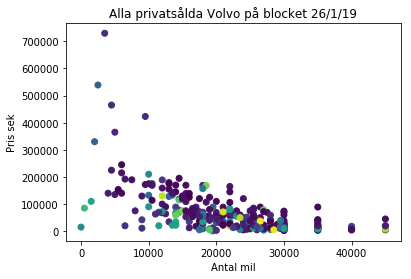

In [31]:
fig, ax = plt.subplots()
scatter = ax.scatter(x = 'from', y = 'price', c = 'model_num', data = volvo_pandas, cmap = 'viridis')
plt.xlabel('Antal mil')
plt.ylabel('Pris sek')
plt.title('Alla privatsålda Volvo på blocket 26/1/19')
plt.show()

A data frame subset containing only the model v70 is stored as v70.

In [32]:
v70 = volvo_pandas[volvo_pandas.model == 'v70']

Removing cars without price and the distance traveled from the data set.

In [33]:
v70 = v70[v70['from'].notnull()]
v70 = v70[v70['price'].notnull()]

A regression line is derived.

In [34]:
b, m = polyfit(v70['from'], v70['price'], 1)

A plot of all Volvo v70 cars in the data set are displayed with a regression 

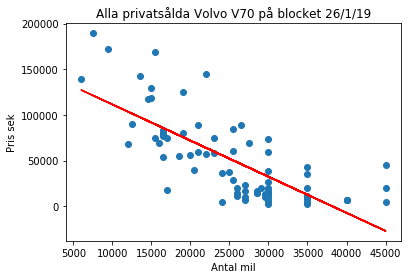

In [35]:
fig, ax = plt.subplots()
plt.scatter = ax.scatter(x = 'from', y = 'price', data = v70)
plt.plot(v70['from'], b + m * v70['from'], '-', c = 'r')
plt.xlabel('Antal mil')
plt.ylabel('Pris sek')
plt.title('Alla privatsålda Volvo V70 på blocket 26/1/19')
plt.show()